In [ ]:
"""
A Tri-Objective Optimization Framework for Selecting Construction Safety Interventions
Balancing Risk, Complexity, and Generalizability

This implementation uses NSGA-III for multi-objective optimization of safety interventions
across three competing objectives: Risk (severity), Complexity (semantic friction),
and Generalizability (intervention applicability).

Required packages:
pip install sentence-transformers pymoo scikit-learn pandas numpy matplotlib seaborn kneed scipy tqdm
"""

import os
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.indicators.hv import HV
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

# =========================================
# CONFIGURATION
# =========================================
BASE_DIR = "/content/research_output"
LOG_DIR = os.path.join(BASE_DIR, "logs")
FIG_DIR = os.path.join(BASE_DIR, "figures")
DATA_DIR = os.path.join(BASE_DIR, "data")
STRUCTURED_JSON = "/content/structured_osha.json"

for d in [BASE_DIR, LOG_DIR, FIG_DIR, DATA_DIR]:
    os.makedirs(d, exist_ok=True)

SEED = 42
np.random.seed(SEED)

# Journal-quality plot settings
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
})

# =========================================
# PHASE 2: EMBEDDING & METRIC CALCULATION
# =========================================
class SafetyInterventionAnalyzer:
    """Computes embeddings and calculates the three objectives"""

    def __init__(self, model_name='all-MiniLM-L12-v2'):
        print(f"[PHASE 2] Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name)

    def load_data(self, json_path):
        """Load structured data from Phase 1"""
        print(f"[PHASE 2] Loading data from {json_path}")
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Filter valid records
        valid_records = []
        for rec in data:
            if all(k in rec for k in ['unsafe_action', 'safe_alternative', 'severity']):
                if rec['unsafe_action'] and rec['safe_alternative']:
                    valid_records.append(rec)

        print(f"[PHASE 2] Loaded {len(valid_records)} valid intervention pairs")
        return pd.DataFrame(valid_records)

    def compute_embeddings(self, df):
        """Generate embeddings for unsafe actions and safe alternatives"""
        print("[PHASE 2] Computing embeddings...")

        unsafe_texts = df['unsafe_action'].tolist()
        safe_texts = df['safe_alternative'].tolist()

        df['unsafe_embedding'] = list(self.model.encode(unsafe_texts, show_progress_bar=True))
        df['safe_embedding'] = list(self.model.encode(safe_texts, show_progress_bar=True))

        return df

    def calculate_objectives(self, df):
        """
        Calculate three objectives:
        1. Risk (Severity) - to minimize
        2. Complexity (Semantic Friction) - to minimize
        3. Generalizability (Average similarity to other interventions) - to maximize
        """
        print("[PHASE 2] Calculating three objectives...")

        # Objective 1: Risk (already in data)
        df['obj_risk'] = df['severity']

        # Objective 2: Complexity (cosine distance between unsafe and safe)
        df['obj_complexity'] = df.apply(
            lambda row: 1 - cosine_similarity(
                [row['unsafe_embedding']],
                [row['safe_embedding']]
            )[0][0],
            axis=1
        )

        # Objective 3: Generalizability (average similarity to all other safe alternatives)
        safe_embeddings = np.vstack(df['safe_embedding'].values)
        similarity_matrix = cosine_similarity(safe_embeddings)

        # For each intervention, calculate mean similarity to others (excluding self)
        generalizability = []
        for i in range(len(similarity_matrix)):
            # Exclude self-similarity
            other_sims = np.concatenate([similarity_matrix[i, :i], similarity_matrix[i, i+1:]])
            generalizability.append(np.mean(other_sims))

        df['obj_generalizability'] = generalizability

        print(f"Objective ranges:")
        print(f"  Risk: [{df['obj_risk'].min():.2f}, {df['obj_risk'].max():.2f}]")
        print(f"  Complexity: [{df['obj_complexity'].min():.3f}, {df['obj_complexity'].max():.3f}]")
        print(f"  Generalizability: [{df['obj_generalizability'].min():.3f}, {df['obj_generalizability'].max():.3f}]")

        return df

# =========================================
# PHASE 3: HAZARD CLUSTERING
# =========================================
def determine_optimal_clusters(df, max_clusters=10, method='elbow'):
    """
    Use elbow method and silhouette analysis to determine optimal number of clusters

    Parameters:
    - df: DataFrame with state_keywords
    - max_clusters: Maximum number of clusters to test
    - method: 'elbow', 'silhouette', or 'both'

    Returns:
    - optimal_k: Recommended number of clusters
    - state_embeddings: Embeddings for clustering
    - metrics: Dictionary with inertia and silhouette scores
    """
    from sklearn.metrics import silhouette_score
    from kneed import KneeLocator

    print(f"[PHASE 3A] Determining optimal number of clusters (max={max_clusters})...")

    # Generate embeddings
    state_texts = df['state_keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    model = SentenceTransformer('all-MiniLM-L6-v2')
    state_embeddings = model.encode(state_texts.tolist(), show_progress_bar=False)

    # Test different numbers of clusters
    K_range = range(2, min(max_clusters + 1, len(df) // 2))  # Ensure at least 2 samples per cluster
    inertias = []
    silhouette_scores = []

    print(f"  Testing k from 2 to {max(K_range)}...")

    for k in tqdm(K_range, desc="Evaluating clusters"):
        kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        labels = kmeans.fit_predict(state_embeddings)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(state_embeddings, labels))

    # Find elbow point using kneed library
    kl = KneeLocator(list(K_range), inertias, curve='convex', direction='decreasing')
    elbow_k = kl.elbow if kl.elbow else K_range[len(K_range)//2]

    # Find best silhouette score
    silhouette_k = K_range[np.argmax(silhouette_scores)]

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow plot
    axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    if elbow_k:
        axes[0].axvline(x=elbow_k, color='red', linestyle='--', linewidth=2,
                       label=f'Elbow at k={elbow_k}')
        axes[0].plot(elbow_k, inertias[list(K_range).index(elbow_k)], 'r*',
                    markersize=20, label='Elbow Point')

    axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
    axes[0].set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=11)
    axes[0].set_title('(a) Elbow Method', fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3, linestyle='--')
    axes[0].legend(fontsize=9)

    # Silhouette plot
    axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    axes[1].axvline(x=silhouette_k, color='red', linestyle='--', linewidth=2,
                   label=f'Max at k={silhouette_k}')
    axes[1].plot(silhouette_k, silhouette_scores[list(K_range).index(silhouette_k)], 'r*',
                markersize=20, label='Maximum')

    axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
    axes[1].set_ylabel('Silhouette Score', fontsize=11)
    axes[1].set_title('(b) Silhouette Analysis', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3, linestyle='--')
    axes[1].legend(fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig0_optimal_clusters.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'fig0_optimal_clusters.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure 0: Optimal Cluster Determination")
    plt.close()

    # Decision logic
    if method == 'elbow':
        optimal_k = elbow_k
    elif method == 'silhouette':
        optimal_k = silhouette_k
    else:  # 'both' - use average or elbow as primary
        optimal_k = elbow_k if elbow_k else silhouette_k

    print(f"\n  Elbow Method suggests: k = {elbow_k}")
    print(f"  Silhouette Analysis suggests: k = {silhouette_k}")
    print(f"  Selected optimal k = {optimal_k}")
    print(f"  Silhouette Score at k={optimal_k}: {silhouette_scores[list(K_range).index(optimal_k)]:.3f}")

    metrics = {
        'K_range': list(K_range),
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'elbow_k': elbow_k,
        'silhouette_k': silhouette_k,
        'optimal_k': optimal_k
    }

    return optimal_k, state_embeddings, metrics

def cluster_hazards(df, n_clusters=None, max_clusters=10):
    """
    Cluster interventions by state keywords
    If n_clusters is None, automatically determines optimal number
    """
    if n_clusters is None:
        # Automatically determine optimal clusters
        optimal_k, state_embeddings, metrics = determine_optimal_clusters(df, max_clusters=max_clusters)
        n_clusters = optimal_k

        # Save metrics
        metrics_df = pd.DataFrame({
            'k': metrics['K_range'],
            'inertia': metrics['inertias'],
            'silhouette': metrics['silhouette_scores']
        })
        metrics_df.to_csv(os.path.join(DATA_DIR, 'clustering_metrics.csv'), index=False)
    else:
        # Use specified number of clusters
        print(f"[PHASE 3] Clustering into {n_clusters} hazard groups...")
        state_texts = df['state_keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
        model = SentenceTransformer('all-MiniLM-L6-v2')
        state_embeddings = model.encode(state_texts.tolist())

    # Perform final clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    df['hazard_cluster'] = kmeans.fit_predict(state_embeddings)

    print(f"\n[PHASE 3] Final clustering with k = {n_clusters}")
    print(f"Cluster distribution:")
    cluster_counts = df['hazard_cluster'].value_counts().sort_index()
    print(cluster_counts)

    # =========================================
    # START: ADDED CODE BLOCK
    # =========================================
    print("\n[PHASE 3] Cluster Semantic Themes (Top 10 Keywords):")

    # Ensure 'from collections import Counter' is at the top of your script
    from collections import Counter

    for cluster_id in sorted(df['hazard_cluster'].unique()):
        cluster_data = df[df['hazard_cluster'] == cluster_id]

        # Get all keywords for this cluster
        all_keywords_lists = cluster_data['state_keywords'].tolist()

        # Flatten the list of lists, handling potential non-list entries
        all_keywords = [
            keyword
            for sublist in all_keywords_lists
            if isinstance(sublist, list)
            for keyword in sublist
        ]

        if not all_keywords:
            print(f"  Cluster {cluster_id}: No keywords found.")
            continue

        # Get the 10 most common keywords
        keyword_counts = Counter(all_keywords)
        top_10_keywords = keyword_counts.most_common(10)

        # Format for printing
        theme = ', '.join([f"'{k}' ({v})" for k, v in top_10_keywords])
        print(f"  Cluster {cluster_id} Theme: {theme}")
    # =========================================
    # END: ADDED CODE BLOCK
    # =========================================

    # Calculate and display cluster characteristics
    print(f"\nCluster Characteristics:")
    for cluster_id in sorted(df['hazard_cluster'].unique()):
        cluster_data = df[df['hazard_cluster'] == cluster_id]
        print(f"  Cluster {cluster_id}: n={len(cluster_data)}, "
              f"Avg Risk={cluster_data['obj_risk'].mean():.2f}, "
              f"Avg Complexity={cluster_data['obj_complexity'].mean():.3f}, "
              f"Avg Generalizability={cluster_data['obj_generalizability'].mean():.3f}")

    return df

# =========================================
# PHASE 4: TRI-OBJECTIVE OPTIMIZATION (NSGA-III)
# =========================================
class SafetyInterventionProblem(Problem):
    """
    Multi-objective problem for NSGA-III
    Minimizes: Risk, Complexity, -Generalizability (negative to maximize)
    """

    def __init__(self, interventions_df):
        self.df = interventions_df
        n_interventions = len(interventions_df)

        super().__init__(
            n_var=n_interventions,  # Binary selection variables
            n_obj=3,  # Three objectives
            n_constr=0,
            xl=0,  # Lower bound (not selected)
            xu=1   # Upper bound (selected)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        """Evaluate objectives for each solution"""
        # X is population_size x n_interventions matrix of binary decisions

        f1 = []  # Risk (minimize)
        f2 = []  # Complexity (minimize)
        f3 = []  # -Generalizability (minimize, so we maximize generalizability)

        for solution in X:
            selected = solution > 0.5  # Binary threshold

            if selected.sum() == 0:
                # If nothing selected, assign worst possible scores
                f1.append(10.0)
                f2.append(1.0)
                f3.append(0.0)
            else:
                selected_rows = self.df[selected]

                # Aggregate objectives (using mean)
                f1.append(selected_rows['obj_risk'].mean())
                f2.append(selected_rows['obj_complexity'].mean())
                f3.append(-selected_rows['obj_generalizability'].mean())  # Negative to maximize

        out["F"] = np.column_stack([f1, f2, f3])

def run_optimization_per_cluster(df, cluster_id, n_gen=100):
    """Run NSGA-III optimization for a specific hazard cluster"""
    print(f"\n[PHASE 4] Optimizing Cluster {cluster_id}...")

    cluster_df = df[df['hazard_cluster'] == cluster_id].reset_index(drop=True)

    if len(cluster_df) < 3:
        print(f"  Skipping cluster {cluster_id}: too few interventions ({len(cluster_df)})")
        return None

    # Define problem
    problem = SafetyInterventionProblem(cluster_df)

    # Reference directions for NSGA-III (3 objectives)
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

    # Initialize algorithm
    algorithm = NSGA3(
        ref_dirs=ref_dirs,
        pop_size=100,
        eliminate_duplicates=True
    )

    # Run optimization
    res = minimize(
        problem,
        algorithm,
        ('n_gen', n_gen),
        seed=SEED,
        verbose=False
    )

    print(f"  Found {len(res.F)} Pareto-optimal solutions")

    return {
        'cluster_id': cluster_id,
        'n_interventions': len(cluster_df),
        'pareto_front': res.F,
        'pareto_solutions': res.X,
        'cluster_data': cluster_df
    }

# =========================================
# PHASE 5: VALIDATION & ANALYSIS
# =========================================
def calculate_hypervolume(pareto_front, ref_point):
    """Calculate hypervolume indicator for 3D Pareto front"""
    ind = HV(ref_point=ref_point)
    hv = ind(pareto_front)
    return hv

def validate_generalizability_metric(df):
    """
    Validate generalizability metric by correlating with linguistic features
    High-generalizability interventions should use more common vocabulary
    """
    print("\n[PHASE 5] Validating Generalizability Metric...")

    from sklearn.feature_extraction.text import CountVectorizer

    # Extract linguistic features
    safe_texts = df['safe_alternative'].tolist()

    # Word count (shorter = more general)
    df['word_count'] = df['safe_alternative'].apply(lambda x: len(str(x).split()))

    # Vocabulary diversity (using term frequency)
    vectorizer = CountVectorizer(max_features=100)
    X = vectorizer.fit_transform(safe_texts)

    # Calculate term frequency for each intervention
    df['vocab_commonality'] = X.sum(axis=1).A1  # Higher = uses more common words

    # Correlations
    corr_word_count = spearmanr(df['obj_generalizability'], df['word_count'])
    corr_vocab = pearsonr(df['obj_generalizability'], df['vocab_commonality'])

    print(f"Correlation with word count: ρ = {corr_word_count[0]:.3f} (p = {corr_word_count[1]:.4f})")
    print(f"Correlation with vocab commonality: r = {corr_vocab[0]:.3f} (p = {corr_vocab[1]:.4f})")

    return {
        'word_count_corr': corr_word_count,
        'vocab_commonality_corr': corr_vocab
    }

# =========================================
# PHASE 6: VISUALIZATION
# =========================================
def create_comprehensive_figures(df, optimization_results, validation_results):
    """Generate all figures for journal publication"""

    print("\n[PHASE 6] Creating publication-quality figures...")

    # Figure 1: Objective Distributions and Correlations
    fig1, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Histograms
    axes[0, 0].hist(df['obj_risk'], bins=30, color='#E74C3C', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Risk (Severity)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('(a) Risk Distribution')

    axes[0, 1].hist(df['obj_complexity'], bins=30, color='#3498DB', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Complexity (Semantic Friction)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('(b) Complexity Distribution')

    axes[0, 2].hist(df['obj_generalizability'], bins=30, color='#2ECC71', alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('Generalizability')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('(c) Generalizability Distribution')

    # Scatter plots showing correlations
    axes[1, 0].scatter(df['obj_risk'], df['obj_complexity'], alpha=0.5, s=20, color='purple')
    axes[1, 0].set_xlabel('Risk')
    axes[1, 0].set_ylabel('Complexity')
    axes[1, 0].set_title('(d) Risk vs Complexity')
    r_rc = np.corrcoef(df['obj_risk'], df['obj_complexity'])[0, 1]
    axes[1, 0].text(0.05, 0.95, f'r = {r_rc:.3f}', transform=axes[1, 0].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    axes[1, 1].scatter(df['obj_risk'], df['obj_generalizability'], alpha=0.5, s=20, color='orange')
    axes[1, 1].set_xlabel('Risk')
    axes[1, 1].set_ylabel('Generalizability')
    axes[1, 1].set_title('(e) Risk vs Generalizability')
    r_rg = np.corrcoef(df['obj_risk'], df['obj_generalizability'])[0, 1]
    axes[1, 1].text(0.05, 0.95, f'r = {r_rg:.3f}', transform=axes[1, 1].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    axes[1, 2].scatter(df['obj_complexity'], df['obj_generalizability'], alpha=0.5, s=20, color='teal')
    axes[1, 2].set_xlabel('Complexity')
    axes[1, 2].set_ylabel('Generalizability')
    axes[1, 2].set_title('(f) Complexity vs Generalizability')
    r_cg = np.corrcoef(df['obj_complexity'], df['obj_generalizability'])[0, 1]
    axes[1, 2].text(0.05, 0.95, f'r = {r_cg:.3f}', transform=axes[1, 2].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig1_objective_distributions.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'fig1_objective_distributions.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure 1: Objective Distributions")
    plt.close()

    # Figure 2: 3D Pareto Fronts for Each Cluster
    n_clusters = len([r for r in optimization_results if r is not None])

    # Dynamically calculate grid size
    if n_clusters <= 4:
        nrows, ncols = 2, 2
    elif n_clusters <= 6:
        nrows, ncols = 2, 3
    elif n_clusters <= 9:
        nrows, ncols = 3, 3
    elif n_clusters <= 12:
        nrows, ncols = 3, 4
    else:
        nrows, ncols = 4, 4

    fig2 = plt.figure(figsize=(6*ncols, 5*nrows))

    for idx, result in enumerate(optimization_results):
        if result is None:
            continue

        ax = fig2.add_subplot(nrows, ncols, idx + 1, projection='3d')

        pareto = result['pareto_front']

        # Transform back (remember obj3 was negated)
        risk = pareto[:, 0]
        complexity = pareto[:, 1]
        generalizability = -pareto[:, 2]  # Flip back

        scatter = ax.scatter(risk, complexity, generalizability,
                           c=generalizability, cmap='viridis', s=50, alpha=0.7, edgecolors='black')

        ax.set_xlabel('Risk →', fontsize=9)
        ax.set_ylabel('Complexity →', fontsize=9)
        ax.set_zlabel('Generalizability →', fontsize=9)
        ax.set_title(f'Cluster {result["cluster_id"]} (n={result["n_interventions"]})', fontsize=10)
        ax.view_init(elev=20, azim=45)

        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Generalizability')

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig2_3d_pareto_fronts.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'fig2_3d_pareto_fronts.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure 2: 3D Pareto Fronts")
    plt.close()

    # Figure 3: Hypervolume Comparison Across Clusters
    fig3, ax = plt.subplots(1, 1, figsize=(10, 6))

    hypervolumes = []
    cluster_ids = []
    n_interventions_list = []

    # Reference point for hypervolume (worst possible values)
    ref_point = np.array([10.0, 1.0, 0.0])  # Risk max, Complexity max, -Generalizability max

    for result in optimization_results:
        if result is None:
            continue
        hv = calculate_hypervolume(result['pareto_front'], ref_point)
        hypervolumes.append(hv)
        cluster_ids.append(result['cluster_id'])
        n_interventions_list.append(result['n_interventions'])

    colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_ids)))
    bars = ax.bar(range(len(cluster_ids)), hypervolumes, color=colors, edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Hazard Cluster', fontsize=11)
    ax.set_ylabel('Hypervolume Indicator', fontsize=11)
    ax.set_title('Pareto Front Quality Across Hazard Clusters', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(cluster_ids)))
    ax.set_xticklabels([f'C{cid}\n(n={n})' for cid, n in zip(cluster_ids, n_interventions_list)])
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for i, (bar, hv) in enumerate(zip(bars, hypervolumes)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{hv:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig3_hypervolume_comparison.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'fig3_hypervolume_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure 3: Hypervolume Comparison")
    plt.close()

    # Figure 4: Generalizability Validation
    fig4, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Word count correlation
    axes[0].scatter(df['obj_generalizability'], df['word_count'], alpha=0.5, s=30, color='#9B59B6')
    axes[0].set_xlabel('Generalizability Score', fontsize=11)
    axes[0].set_ylabel('Word Count', fontsize=11)
    axes[0].set_title('(a) Generalizability vs Word Count', fontsize=12)

    # Add trend line
    z = np.polyfit(df['obj_generalizability'], df['word_count'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df['obj_generalizability'].min(), df['obj_generalizability'].max(), 100)
    axes[0].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

    rho, p_val = validation_results['word_count_corr']
    axes[0].text(0.05, 0.95, f'ρ = {rho:.3f}\np = {p_val:.4f}',
                transform=axes[0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[0].grid(alpha=0.3, linestyle='--')

    # Vocabulary commonality correlation
    axes[1].scatter(df['obj_generalizability'], df['vocab_commonality'], alpha=0.5, s=30, color='#E67E22')
    axes[1].set_xlabel('Generalizability Score', fontsize=11)
    axes[1].set_ylabel('Vocabulary Commonality', fontsize=11)
    axes[1].set_title('(b) Generalizability vs Vocabulary Commonality', fontsize=12)

    # Add trend line
    z2 = np.polyfit(df['obj_generalizability'], df['vocab_commonality'], 1)
    p2 = np.poly1d(z2)
    axes[1].plot(x_line, p2(x_line), "r--", alpha=0.8, linewidth=2)

    r, p_val2 = validation_results['vocab_commonality_corr']
    axes[1].text(0.05, 0.95, f'r = {r:.3f}\np = {p_val2:.4f}',
                transform=axes[1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[1].grid(alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig4_generalizability_validation.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'fig4_generalizability_validation.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure 4: Generalizability Validation")
    plt.close()

    # Figure 5: Example Pareto Solutions (Trade-off Analysis)
    if optimization_results[0] is not None:
        fig5 = plt.figure(figsize=(16, 5))

        result = optimization_results[0]  # Use first cluster as example
        pareto = result['pareto_front']

        # Create three 2D projections
        ax1 = fig5.add_subplot(131)
        scatter1 = ax1.scatter(pareto[:, 0], pareto[:, 1], c=-pareto[:, 2],
                              cmap='plasma', s=80, alpha=0.7, edgecolors='black')
        ax1.set_xlabel('Risk (Severity)', fontsize=11)
        ax1.set_ylabel('Complexity (Semantic Friction)', fontsize=11)
        ax1.set_title('(a) Risk-Complexity Trade-off', fontsize=12)
        ax1.grid(alpha=0.3, linestyle='--')
        plt.colorbar(scatter1, ax=ax1, label='Generalizability')

        ax2 = fig5.add_subplot(132)
        scatter2 = ax2.scatter(pareto[:, 0], -pareto[:, 2], c=pareto[:, 1],
                              cmap='plasma', s=80, alpha=0.7, edgecolors='black')
        ax2.set_xlabel('Risk (Severity)', fontsize=11)
        ax2.set_ylabel('Generalizability', fontsize=11)
        ax2.set_title('(b) Risk-Generalizability Trade-off', fontsize=12)
        ax2.grid(alpha=0.3, linestyle='--')
        plt.colorbar(scatter2, ax=ax2, label='Complexity')

        ax3 = fig5.add_subplot(133)
        scatter3 = ax3.scatter(pareto[:, 1], -pareto[:, 2], c=pareto[:, 0],
                              cmap='plasma', s=80, alpha=0.7, edgecolors='black')
        ax3.set_xlabel('Complexity (Semantic Friction)', fontsize=11)
        ax3.set_ylabel('Generalizability', fontsize=11)
        ax3.set_title('(c) Complexity-Generalizability Trade-off', fontsize=12)
        ax3.grid(alpha=0.3, linestyle='--')
        plt.colorbar(scatter3, ax=ax3, label='Risk')

        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'fig5_tradeoff_projections.pdf'), dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(FIG_DIR, 'fig5_tradeoff_projections.png'), dpi=300, bbox_inches='tight')
        print(f"  Saved Figure 5: Trade-off Projections")
        plt.close()

def generate_summary_statistics(df, optimization_results):
    """Generate summary statistics table for paper"""
    print("\n[PHASE 6] Generating Summary Statistics...")

    stats = {
        'Total Interventions': len(df),
        'Risk Mean (SD)': f"{df['obj_risk'].mean():.2f} ({df['obj_risk'].std():.2f})",
        'Risk Range': f"[{df['obj_risk'].min():.0f}, {df['obj_risk'].max():.0f}]",
        'Complexity Mean (SD)': f"{df['obj_complexity'].mean():.3f} ({df['obj_complexity'].std():.3f})",
        'Complexity Range': f"[{df['obj_complexity'].min():.3f}, {df['obj_complexity'].max():.3f}]",
        'Generalizability Mean (SD)': f"{df['obj_generalizability'].mean():.3f} ({df['obj_generalizability'].std():.3f})",
        'Generalizability Range': f"[{df['obj_generalizability'].min():.3f}, {df['obj_generalizability'].max():.3f}]",
        'Number of Clusters': len([r for r in optimization_results if r is not None]),
    }

    # Calculate average Pareto front size
    pareto_sizes = [len(r['pareto_front']) for r in optimization_results if r is not None]
    stats['Avg Pareto Solutions per Cluster'] = f"{np.mean(pareto_sizes):.1f} ({np.std(pareto_sizes):.1f})"

    # Save to file
    stats_df = pd.DataFrame(list(stats.items()), columns=['Metric', 'Value'])
    stats_df.to_csv(os.path.join(DATA_DIR, 'summary_statistics.csv'), index=False)

    print("\nSummary Statistics:")
    for key, val in stats.items():
        print(f"  {key}: {val}")

    return stats

# =========================================
# MAIN EXECUTION PIPELINE
# =========================================
def main():
    """Execute complete analysis pipeline"""

    print("="*80)
    print("TRI-OBJECTIVE OPTIMIZATION FOR CONSTRUCTION SAFETY INTERVENTIONS")
    print("="*80)

    # Phase 2: Load and process data
    analyzer = SafetyInterventionAnalyzer()
    df = analyzer.load_data(STRUCTURED_JSON)
    df = analyzer.compute_embeddings(df)
    df = analyzer.calculate_objectives(df)

    # Save processed data
    df.to_pickle(os.path.join(DATA_DIR, 'processed_interventions.pkl'))

    # Phase 3: Cluster hazards (automatically determine optimal k)
    df = cluster_hazards(df, n_clusters=None, max_clusters=10)  # None = auto-detect

    # Phase 4: Run optimization for each cluster
    optimization_results = []
    for cluster_id in sorted(df['hazard_cluster'].unique()):
        result = run_optimization_per_cluster(df, cluster_id, n_gen=100)
        optimization_results.append(result)

    # Save optimization results
    import pickle
    with open(os.path.join(DATA_DIR, 'optimization_results.pkl'), 'wb') as f:
        pickle.dump(optimization_results, f)

    # Phase 5: Validation
    validation_results = validate_generalizability_metric(df)

    # Phase 6: Generate figures and statistics
    create_comprehensive_figures(df, optimization_results, validation_results)
    summary_stats = generate_summary_statistics(df, optimization_results)

    print("\n" + "="*80)
    print("ANALYSIS COMPLETE!")
    print(f"All outputs saved to: {BASE_DIR}")
    print(f"  - Figures: {FIG_DIR}")
    print(f"  - Data: {DATA_DIR}")
    print(f"  - Logs: {LOG_DIR}")
    print("="*80)

    return df, optimization_results, validation_results, summary_stats

# =========================================
# ADDITIONAL ANALYSIS FUNCTIONS
# =========================================
def export_pareto_solutions_table(optimization_results, output_path):
    """Export representative Pareto solutions for each cluster as a table"""

    print("\n[EXPORT] Creating Pareto solutions table...")

    all_solutions = []

    for result in optimization_results:
        if result is None:
            continue

        cluster_id = result['cluster_id']
        pareto = result['pareto_front']

        # Select representative solutions (extreme points + knee point)
        # 1. Minimum risk
        idx_min_risk = np.argmin(pareto[:, 0])
        # 2. Minimum complexity
        idx_min_complexity = np.argmin(pareto[:, 1])
        # 3. Maximum generalizability (remember it's negated)
        idx_max_gen = np.argmin(pareto[:, 2])
        # 4. Knee point (closest to ideal point)
        ideal = np.array([pareto[:, 0].min(), pareto[:, 1].min(), pareto[:, 2].min()])
        distances = np.linalg.norm(pareto - ideal, axis=1)
        idx_knee = np.argmin(distances)

        representative_indices = [idx_min_risk, idx_min_complexity, idx_max_gen, idx_knee]
        labels = ['Min Risk', 'Min Complexity', 'Max Generalizability', 'Balanced (Knee)']

        for idx, label in zip(representative_indices, labels):
            all_solutions.append({
                'Cluster': cluster_id,
                'Solution_Type': label,
                'Risk': pareto[idx, 0],
                'Complexity': pareto[idx, 1],
                'Generalizability': -pareto[idx, 2]  # Flip back
            })

    solutions_df = pd.DataFrame(all_solutions)
    solutions_df.to_csv(output_path, index=False)
    print(f"  Saved representative solutions to: {output_path}")

    return solutions_df

def analyze_intervention_characteristics(df, output_path):
    """Analyze characteristics of high vs low generalizability interventions"""

    print("\n[ANALYSIS] Analyzing intervention characteristics...")

    # Divide into quartiles
    q1 = df['obj_generalizability'].quantile(0.25)
    q3 = df['obj_generalizability'].quantile(0.75)

    low_gen = df[df['obj_generalizability'] <= q1]
    high_gen = df[df['obj_generalizability'] >= q3]

    analysis = {
        'Metric': [
            'Count',
            'Avg Risk (Severity)',
            'Avg Complexity',
            'Avg Word Count',
            'Avg Vocab Commonality'
        ],
        'Low Generalizability (Q1)': [
            len(low_gen),
            f"{low_gen['obj_risk'].mean():.2f}",
            f"{low_gen['obj_complexity'].mean():.3f}",
            f"{low_gen['word_count'].mean():.2f}",
            f"{low_gen['vocab_commonality'].mean():.2f}"
        ],
        'High Generalizability (Q3)': [
            len(high_gen),
            f"{high_gen['obj_risk'].mean():.2f}",
            f"{high_gen['obj_complexity'].mean():.3f}",
            f"{high_gen['word_count'].mean():.2f}",
            f"{high_gen['vocab_commonality'].mean():.2f}"
        ]
    }

    analysis_df = pd.DataFrame(analysis)
    analysis_df.to_csv(output_path, index=False)
    print(f"  Saved intervention characteristics to: {output_path}")

    # Print examples
    print("\n  Examples of LOW generalizability interventions:")
    for idx, row in low_gen.nsmallest(3, 'obj_generalizability').iterrows():
        print(f"    - {row['safe_alternative']} (score: {row['obj_generalizability']:.3f})")

    print("\n  Examples of HIGH generalizability interventions:")
    for idx, row in high_gen.nlargest(3, 'obj_generalizability').iterrows():
        print(f"    - {row['safe_alternative']} (score: {row['obj_generalizability']:.3f})")

    return analysis_df

def create_supplementary_figures(df, optimization_results):
    """Create additional figures for supplementary materials"""

    print("\n[SUPPLEMENTARY] Creating additional figures...")

    # S1: Cluster characteristics heatmap
    fig_s1, ax = plt.subplots(figsize=(10, 6))

    cluster_summary = df.groupby('hazard_cluster').agg({
        'obj_risk': 'mean',
        'obj_complexity': 'mean',
        'obj_generalizability': 'mean'
    }).T

    sns.heatmap(cluster_summary, annot=True, fmt='.3f', cmap='YlOrRd',
                cbar_kws={'label': 'Mean Value'}, ax=ax, linewidths=1, linecolor='black')
    ax.set_xlabel('Hazard Cluster', fontsize=11)
    ax.set_ylabel('Objective', fontsize=11)
    ax.set_title('Mean Objective Values by Hazard Cluster', fontsize=12, fontweight='bold')
    ax.set_yticklabels(['Risk', 'Complexity', 'Generalizability'], rotation=0)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figS1_cluster_heatmap.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'figS1_cluster_heatmap.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure S1: Cluster Heatmap")
    plt.close()

    # S2: Pareto front sizes distribution
    fig_s2, ax = plt.subplots(figsize=(10, 6))

    pareto_sizes = [len(r['pareto_front']) for r in optimization_results if r is not None]
    cluster_ids = [r['cluster_id'] for r in optimization_results if r is not None]

    bars = ax.bar(range(len(cluster_ids)), pareto_sizes, color='steelblue',
                  edgecolor='black', linewidth=1.5, alpha=0.7)

    ax.set_xlabel('Hazard Cluster', fontsize=11)
    ax.set_ylabel('Number of Pareto-Optimal Solutions', fontsize=11)
    ax.set_title('Pareto Front Size by Cluster', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(cluster_ids)))
    ax.set_xticklabels([f'Cluster {cid}' for cid in cluster_ids])
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    for bar, size in zip(bars, pareto_sizes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{size}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figS2_pareto_sizes.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'figS2_pareto_sizes.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure S2: Pareto Front Sizes")
    plt.close()

    # S3: Objective correlations by cluster
    n_clusters_total = len(df['hazard_cluster'].unique())

    # Dynamically calculate grid size
    if n_clusters_total <= 4:
        nrows_s3, ncols_s3 = 1, n_clusters_total
        figsize_s3 = (5*n_clusters_total, 4)
    elif n_clusters_total <= 6:
        nrows_s3, ncols_s3 = 2, 3
        figsize_s3 = (15, 8)
    elif n_clusters_total <= 9:
        nrows_s3, ncols_s3 = 3, 3
        figsize_s3 = (15, 12)
    elif n_clusters_total <= 12:
        nrows_s3, ncols_s3 = 3, 4
        figsize_s3 = (20, 12)
    else:
        nrows_s3, ncols_s3 = 4, 4
        figsize_s3 = (20, 16)

    fig_s3, axes = plt.subplots(nrows_s3, ncols_s3, figsize=figsize_s3)

    # Flatten axes for easier indexing
    if n_clusters_total == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()

    for idx, cluster_id in enumerate(sorted(df['hazard_cluster'].unique())):
        cluster_data = df[df['hazard_cluster'] == cluster_id]

        # Compute correlation matrix
        corr_matrix = cluster_data[['obj_risk', 'obj_complexity', 'obj_generalizability']].corr()

        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, vmin=-1, vmax=1, square=True, ax=axes[idx],
                   cbar_kws={'shrink': 0.8}, linewidths=1, linecolor='black')

        axes[idx].set_title(f'Cluster {cluster_id}\n(n={len(cluster_data)})', fontsize=10)
        axes[idx].set_xticklabels(['Risk', 'Complexity', 'General.'], rotation=45, ha='right')
        axes[idx].set_yticklabels(['Risk', 'Complexity', 'General.'], rotation=0)

    # Hide extra subplots if any
    for idx in range(n_clusters_total, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figS3_cluster_correlations.pdf'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, 'figS3_cluster_correlations.png'), dpi=300, bbox_inches='tight')
    print(f"  Saved Figure S3: Cluster Correlations")
    plt.close()

def generate_latex_table(df, optimization_results):
    """Generate LaTeX table code for paper"""

    print("\n[LATEX] Generating LaTeX table...")

    # Calculate hypervolumes
    ref_point = np.array([10.0, 1.0, 0.0])

    latex_rows = []
    latex_rows.append("\\begin{table}[htbp]")
    latex_rows.append("\\centering")
    latex_rows.append("\\caption{Optimization Results by Hazard Cluster}")
    latex_rows.append("\\label{tab:optimization_results}")
    latex_rows.append("\\begin{tabular}{ccccccc}")
    latex_rows.append("\\hline")
    latex_rows.append("Cluster & $n$ & Pareto Size & Hypervolume & Mean Risk & Mean Complexity & Mean Generalizability \\\\")
    latex_rows.append("\\hline")

    for result in optimization_results:
        if result is None:
            continue

        cluster_id = result['cluster_id']
        n_int = result['n_interventions']
        pareto_size = len(result['pareto_front'])
        hv = calculate_hypervolume(result['pareto_front'], ref_point)

        pareto = result['pareto_front']
        mean_risk = pareto[:, 0].mean()
        mean_complexity = pareto[:, 1].mean()
        mean_gen = -pareto[:, 2].mean()  # Flip back

        latex_rows.append(f"{cluster_id} & {n_int} & {pareto_size} & {hv:.3f} & {mean_risk:.2f} & {mean_complexity:.3f} & {mean_gen:.3f} \\\\")

    latex_rows.append("\\hline")
    latex_rows.append("\\end{tabular}")
    latex_rows.append("\\end{table}")

    latex_code = "\n".join(latex_rows)

    with open(os.path.join(DATA_DIR, 'table_optimization_results.tex'), 'w') as f:
        f.write(latex_code)

    print(f"  Saved LaTeX table to: {os.path.join(DATA_DIR, 'table_optimization_results.tex')}")
    print("\nLaTeX Table Preview:")
    print(latex_code)

    return latex_code

# =========================================
# RUN COMPLETE ANALYSIS
# =========================================
if __name__ == "__main__":
    # Run main pipeline
    df, optimization_results, validation_results, summary_stats = main()

    # Export additional analysis
    solutions_table = export_pareto_solutions_table(
        optimization_results,
        os.path.join(DATA_DIR, 'representative_solutions.csv')
    )

    characteristics = analyze_intervention_characteristics(
        df,
        os.path.join(DATA_DIR, 'intervention_characteristics.csv')
    )

    # Create supplementary figures
    create_supplementary_figures(df, optimization_results)

    # Generate LaTeX table
    latex_table = generate_latex_table(df, optimization_results)

    print("\n" + "="*80)
    print("ALL ANALYSES COMPLETE!")
    print("="*80)
    print("\nGenerated Outputs:")
    print("\nPre-Analysis Figure:")
    print("  0. fig0_optimal_clusters.pdf - Elbow method and silhouette analysis")
    print("\nMain Figures (for manuscript):")
    print("  1. fig1_objective_distributions.pdf - Objective distributions and correlations")
    print("  2. fig2_3d_pareto_fronts.pdf - 3D Pareto fronts for each cluster")
    print("  3. fig3_hypervolume_comparison.pdf - Quality comparison across clusters")
    print("  4. fig4_generalizability_validation.pdf - Validation of generalizability metric")
    print("  5. fig5_tradeoff_projections.pdf - 2D projections of trade-offs")
    print("\nSupplementary Figures:")
    print("  S1. figS1_cluster_heatmap.pdf - Mean objectives by cluster")
    print("  S2. figS2_pareto_sizes.pdf - Pareto front size distribution")
    print("  S3. figS3_cluster_correlations.pdf - Objective correlations within clusters")
    print("\nData Tables:")
    print("  - clustering_metrics.csv (elbow method results)")
    print("  - summary_statistics.csv")
    print("  - representative_solutions.csv")
    print("  - intervention_characteristics.csv")
    print("  - table_optimization_results.tex (for LaTeX)")
    print("\nProcessed Data:")
    print("  - processed_interventions.pkl")
    print("  - optimization_results.pkl")
    print("="*80)

ModuleNotFoundError: No module named 'pymoo'

--- [PHASE 2.1] Data Loading and Initial Analysis ---


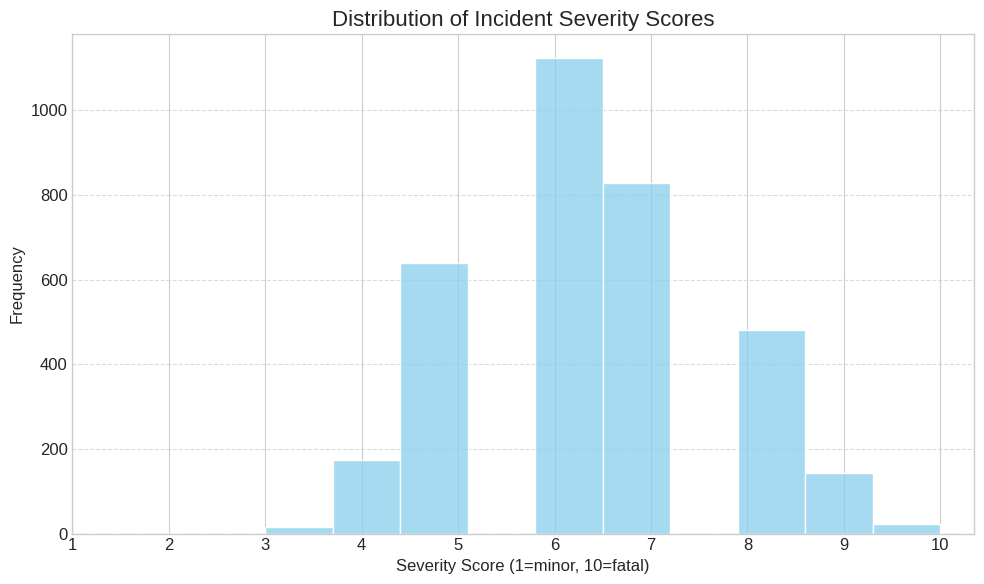


--- [PHASE 2.2] Determining Optimal Number of Action Clusters ---


Batches:   0%|          | 0/108 [00:00<?, ?it/s]

Running K-Means for Elbow Method:   0%|          | 0/39 [00:00<?, ?it/s]

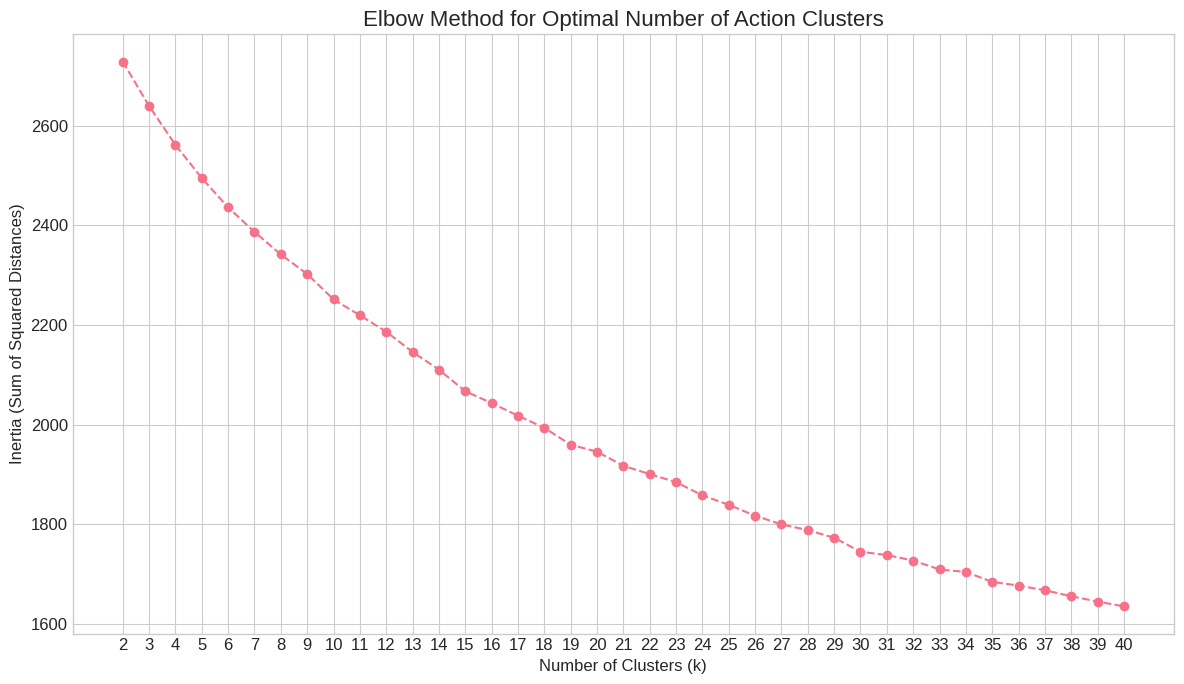

Based on the elbow method plot, proceeding with N_ACTION_CLUSTERS = 20

--- [PHASE 2.3] Creating Discrete Action Space ---


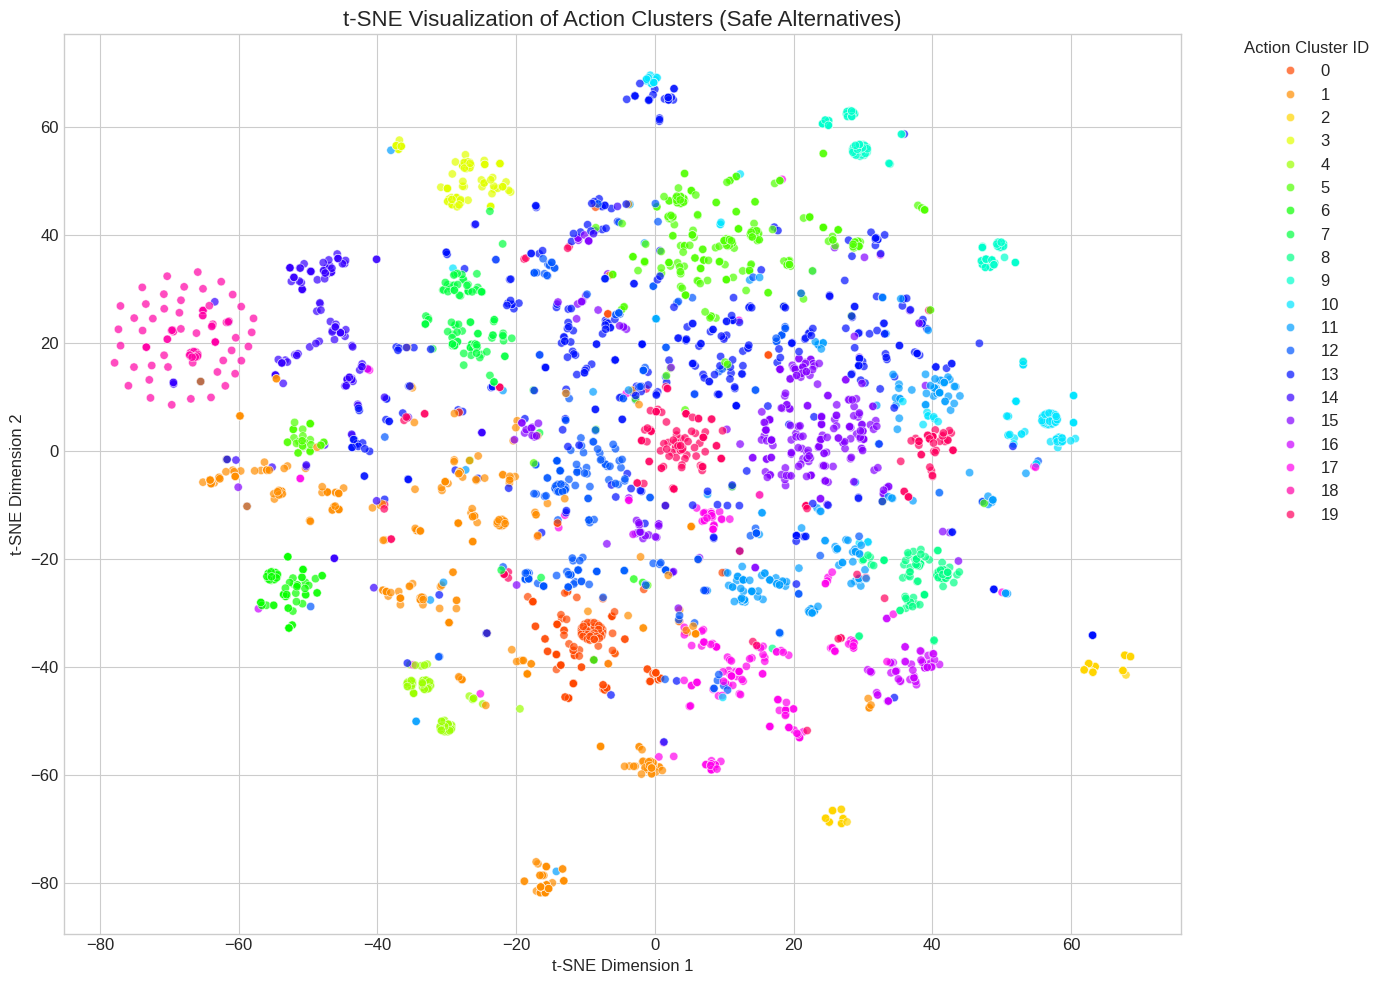


----- Representative Samples for Action Cluster 0 -----
- Maintain safe distance from auger
- Stay out of swing radius
- Maintain safe distance from equipment
- Maintain safe distance from heaters
- Maintain distance during training

----- Representative Samples for Action Cluster 1 -----
- Wear flame-resistant clothing
- Use spotter for backing
- Maintain awareness of equipment
- Use TMA truck for protection
- Maintain eye contact with operator

----- Representative Samples for Action Cluster 2 -----
- Maintain three points of contact
- Use three points of contact
- Maintain three points of contact
- Use three points of contact
- Use three points of contact

----- Representative Samples for Action Cluster 3 -----
- Lockout/Tagout before changing bit
- De-energize and Lockout/Tagout
- Lockout/Tagout before maintenance
- Maintain good housekeeping
- Lockout/Tagout before repairs

----- Representative Samples for Action Cluster 4 -----
- Use blocker vehicle for protection
- Use positive

AttributeError: module 'd3rlpy.dataset' has no attribute 'train_test_split'

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor
from sentence_transformers import SentenceTransformer
import d3rlpy
from d3rlpy.dataset import MDPDataset

# =========================================
# 0. GLOBAL CONFIGURATION & PATHS
# =========================================
BASE_DIR = "/content/research_output"
LOG_DIR = os.path.join(BASE_DIR, "logs")
FIG_DIR = os.path.join(BASE_DIR, "figures")
DATA_DIR = os.path.join(BASE_DIR, "data")
for d in [BASE_DIR, LOG_DIR, FIG_DIR, DATA_DIR]:
    os.makedirs(d, exist_ok=True)

STRUCTURED_JSON = os.path.join(DATA_DIR, 'structured_osha.json')

TEST_SPLIT = 0.2
SEED = 42
RL_TRAINING_EPOCHS = 25
FQE_TRAINING_EPOCHS = 25

random.seed(SEED)
np.random.seed(SEED)
d3rlpy.seed(SEED)
pd.options.mode.chained_assignment = None

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 100

# =========================================
# PHASE 2: DATA PREPROCESSING & FEATURE ENGINEERING
# =========================================
def load_and_clean_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df.dropna(subset=['state_keywords', 'safe_alternative', 'severity'], inplace=True)
    df['state_text'] = df['state_keywords'].apply(lambda x: ' '.join(x))
    df = df[df['state_text'].str.strip().astype(bool)]
    df = df[df['safe_alternative'].str.strip().astype(bool)]
    return df

def determine_optimal_clusters(embeddings, max_clusters=40):
    inertia = []
    cluster_range = range(2, max_clusters + 1)
    for k in tqdm(cluster_range, desc="Running K-Means for Elbow Method"):
        kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        kmeans.fit(embeddings)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(12, 7))
    plt.plot(cluster_range, inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
    plt.title('Elbow Method for Optimal Number of Action Clusters', fontsize=16)
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "elbow_method_plot.png"), dpi=300)
    plt.show()

def create_action_space(df, action_embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    df['action_cluster'] = kmeans.fit_predict(action_embeddings)

    perplexity_value = min(30, len(df) - 1)
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=perplexity_value, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(action_embeddings)

    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1],
        hue=df['action_cluster'],
        palette=sns.color_palette("hsv", n_clusters),
        legend="full",
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Action Clusters (Safe Alternatives)', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(title='Action Cluster ID', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "action_cluster_visualization.png"), dpi=300)
    plt.show()

    for i in range(n_clusters):
        print(f"\n----- Representative Samples for Action Cluster {i} -----")
        sample_actions = df[df['action_cluster'] == i]['safe_alternative'].sample(min(5, len(df[df['action_cluster'] == i])), random_state=SEED).tolist()
        for action in sample_actions:
            print(f"- {action}")

    return df

def prepare_rl_dataset(df):
    state_vectorizer = TfidfVectorizer(max_features=256)
    state_vectors = state_vectorizer.fit_transform(df['state_text']).toarray()

    rewards = -df['severity'].values
    actions = df['action_cluster'].values
    terminals = np.ones_like(rewards)

    dataset = MDPDataset(
        observations=state_vectors.astype('float32'),
        actions=actions.astype('int32'),
        rewards=rewards.astype('float32'),
        terminals=terminals.astype('float32')
    )

    train_dataset, test_dataset = d3rlpy.dataset.train_test_split(dataset, test_size=TEST_SPLIT, random_state=SEED)
    return train_dataset, test_dataset, state_vectorizer

# =========================================
# PHASE 3: OFFLINE RL POLICY LEARNING
# =========================================
def train_rl_policy(train_dataset):
    cql = d3rlpy.algos.CQLConfig(
        seed=SEED,
        alpha=5.0,
        n_action_samples=10,
    ).create(device=False)

    cql.fit(
        train_dataset,
        n_epochs=RL_TRAINING_EPOCHS,
        show_progress=True
    )
    cql.save_model(os.path.join(BASE_DIR, 'cql_policy.d3'))
    return cql

# =========================================
# PHASE 4: VALIDATION AND ANALYSIS
# =========================================
def evaluate_policies_with_fqe(rl_policy, train_dataset, test_dataset, n_actions):
    fqe = d3rlpy.ope.FQEConfig(
        seed=SEED,
        learning_rate=1e-4,
    ).create(device=False)

    fqe.fit(
        train_dataset,
        n_epochs=FQE_TRAINING_EPOCHS,
        show_progress=True
    )

    behavior_policy_score = fqe.predict_value(test_dataset.observations, test_dataset.actions)

    cql_actions = rl_policy.predict(test_dataset.observations)
    cql_policy_score = fqe.predict_value(test_dataset.observations, cql_actions)

    random_actions = np.random.randint(0, n_actions, size=len(test_dataset))
    random_policy_score = fqe.predict_value(test_dataset.observations, random_actions)

    return np.mean(cql_policy_score), np.mean(behavior_policy_score), np.mean(random_policy_score)

def train_and_evaluate_supervised_baseline(df, state_vectorizer, action_embeddings_all):
    df_train, df_test = train_test_split(df, test_size=TEST_SPLIT, random_state=SEED)

    train_indices = df_train.index
    test_indices = df_test.index

    X_train_state = state_vectorizer.transform(df_train['state_text']).toarray()
    X_test_state = state_vectorizer.transform(df_test['state_text']).toarray()

    action_embeddings_train = action_embeddings_all[train_indices]

    X_train = np.hstack([X_train_state, action_embeddings_train])
    y_train = -df_train['severity'].values

    gbr = GradientBoostingRegressor(random_state=SEED, n_estimators=100, max_depth=5)
    gbr.fit(X_train, y_train)

    action_clusters_unique = sorted(df['action_cluster'].unique())

    unique_action_indices = [df.index.get_loc(df[df['action_cluster'] == i].index[0]) for i in action_clusters_unique]
    action_embeddings_unique = action_embeddings_all[unique_action_indices]

    policy_rewards = []
    for i in tqdm(range(X_test_state.shape[0]), desc="Evaluating Supervised Policy"):
        state_vec = X_test_state[i]
        state_repeated = np.tile(state_vec, (len(action_clusters_unique), 1))
        eval_X = np.hstack([state_repeated, action_embeddings_unique])
        predicted_rewards = gbr.predict(eval_X)
        best_action_index = np.argmax(predicted_rewards)
        policy_rewards.append(predicted_rewards[best_action_index])

    return np.mean(policy_rewards)

def plot_evaluation_results(scores):
    policy_names = list(scores.keys())
    policy_values = list(scores.values())

    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=policy_names, y=policy_values, palette="viridis")

    y_min, y_max = min(policy_values), max(policy_values)
    y_range = y_max - y_min
    if y_range == 0: y_range = abs(y_max) if y_max != 0 else 1.0

    for i in range(len(policy_names)):
        ax.text(i, policy_values[i], f'{policy_values[i]:.2f}', ha='center', va='bottom', color='black', fontsize=12,
                xytext=(0, 5), textcoords='offset points')

    plt.title('Off-Policy Evaluation of Safety Intervention Policies', fontsize=16, pad=20)
    plt.ylabel('Estimated Mean Policy Value (Negative Severity)', fontsize=12)
    plt.xlabel('Policy', fontsize=12)
    plt.xticks(fontsize=11)
    plt.ylim(y_min - y_range * 0.1, 0 if y_max <= 0 else y_max + y_range * 0.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "policy_evaluation_comparison.png"), dpi=300)
    plt.show()

def plot_severity_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['severity'], bins=10, kde=False, color='skyblue')
    plt.title('Distribution of Incident Severity Scores', fontsize=16)
    plt.xlabel('Severity Score (1=minor, 10=fatal)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(range(1, 11))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "severity_distribution.png"), dpi=300)
    plt.show()

# =========================================
# MAIN EXECUTION SCRIPT
# =========================================
if __name__ == '__main__':
    if not os.path.exists(STRUCTURED_JSON):
        print(f"ERROR: {STRUCTURED_JSON} not found. Phase 1 must be completed first.")
    else:
        print("--- [PHASE 2.1] Data Loading and Initial Analysis ---")
        main_df = load_and_clean_data(STRUCTURED_JSON)
        plot_severity_distribution(main_df)

        print("\n--- [PHASE 2.2] Determining Optimal Number of Action Clusters ---")
        st_model = SentenceTransformer('all-MiniLM-L6-v2')
        action_embeddings_all = st_model.encode(main_df['safe_alternative'].tolist(), show_progress_bar=True)
        determine_optimal_clusters(action_embeddings_all, max_clusters=40)

        N_ACTION_CLUSTERS = 20
        print(f"Based on the elbow method plot, proceeding with N_ACTION_CLUSTERS = {N_ACTION_CLUSTERS}")

        print("\n--- [PHASE 2.3] Creating Discrete Action Space ---")
        main_df_clustered = create_action_space(main_df.copy(), action_embeddings_all, n_clusters=N_ACTION_CLUSTERS)

        print("\n--- [PHASE 2.4] Preparing Datasets for RL and Supervised Models ---")
        train_dataset, test_dataset, state_vectorizer = prepare_rl_dataset(main_df_clustered)
        print("--- [PHASE 2] Completed ---")

        print("\n--- [PHASE 3] Starting Offline RL Policy Learning (CQL) ---")
        cql_policy = train_rl_policy(train_dataset)
        print("--- [PHASE 3] Completed ---")

        print("\n--- [PHASE 4] Starting Validation and Analysis ---")
        cql_score, behavior_score, random_score = evaluate_policies_with_fqe(cql_policy, train_dataset, test_dataset, N_ACTION_CLUSTERS)

        supervised_score = train_and_evaluate_supervised_baseline(main_df_clustered.reset_index(drop=True), state_vectorizer, action_embeddings_all)

        print("\n--- Evaluation Results ---")
        print(f"CQL Policy Score: {cql_score:.4f}")
        print(f"Behavioral Policy Score: {behavior_score:.4f}")
        print(f"Supervised Baseline Policy Score: {supervised_score:.4f}")
        print(f"Random Policy Score: {random_score:.4f}")

        policy_scores = {
            'Offline RL (CQL)': cql_score,
            'Behavioral (Actual)': behavior_score,
            'Supervised Baseline': supervised_score,
            'Random': random_score,
        }

        plot_evaluation_results(policy_scores)
        print("--- [PHASE 4] Completed. Figures saved to:", FIG_DIR)